In [1]:
import os 
import pandas as pd
from tqdm import tqdm

from pysimx.src.data_types import Order
from pysimx.src.exchange import TOB_Exchange

%load_ext autoreload 
%autoreload 2

In [2]:
# define folder path
# folder_path = 'C:/Users/gobel/code/research_env/keyrock/bi-repo/data/tardis/datasets/'
folder_path = '/Users/jan-gobeli/Code/bi-repo/data/tardis/datasets/'
# folder_path = '/Users/nick-kokkaliaris/Desktop/Keyrock/Keyrock/Tardis Playground/datasets/'
files_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'binance' 
    and f.split('_')[-1] == 'COMPBTC.csv.gz'
    #and f.split('_')[-2] == 'OG'
    and f.split('_')[1] == 'quotes']

In [3]:
ufiles_list = [
    f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) 
    and f.split('_')[0] == 'upbit' 
    and f.split('_')[-1] == 'BTC-COMP.csv.gz'
    #and f.split('_')[-2] == 'OG'
    and f.split('_')[1] == 'quotes']

In [4]:
def get_data(files_list):
    df = pd.DataFrame()
    # Use a loop to get all the csv.gz files from the path location in a single Dataframe
    for csv_file in tqdm(files_list):
        file_name = (folder_path + csv_file)
        if file_name[-2:] == "gz":
            df1 = pd.read_csv(file_name, compression='gzip')
            # Concatenate all the dataframes into a single dataframe
            df = pd.concat([df, df1], ignore_index=True)

    df['time'] = pd.to_datetime(df.timestamp, unit='us')
    df.set_index('time', inplace=True)
    return df

In [5]:
upbit_data = get_data(ufiles_list)
binance_data = get_data(files_list)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 17.24it/s]


In [6]:
binance_lst = binance_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()
upbit_lst = upbit_data[['timestamp', 'bid_amount', 'bid_price', 'ask_price', 'ask_amount']].sort_values('timestamp').to_numpy()

In [7]:
base = 'COMP'
quote = 'BTC'
symbol = base + quote

hedging = TOB_Exchange(latency=[5000, 0.29])
hedging.add_market(symbol, base, quote)
hedging.add_balance(base, 10)
hedging.add_balance(quote, 0.1)
hedging.load_tob(binance_lst, symbol)

In [8]:
origin = TOB_Exchange(latency=[5000, 0.29])
origin.add_market(symbol, base, quote)
origin.add_balance(base, 10)
origin.add_balance(quote, 0.1)
origin.load_tob(upbit_lst, symbol)

In [9]:
origin.fetch_tob('COMPBTC')

{'timestamp': 1688256000295352.2,
 'bid_quantity': 9.27252622,
 'bid_price': 0.00171673,
 'ask_price': 0.00172814,
 'ask_quantity': 193.00703104}

In [10]:
class cross_exchange(): 
    def __init__(self):
        self.symbol = 'COMPBTC'
        self.amount = 4

        self.distance = 10 / 10_000 # place orders at 10bps distance
        self.sensitivity = 4 / 10_000 # after a move of 4bps, replace the order

        self.last_trade = None

        self.timestamp = None

        self.current_bid = None 
        self.current_ask = None

        self.hedging_ask = None 
        self.hedging_bid = None

    def run_strategy(self):

        hedging_tob = hedging.fetch_tob(self.symbol)
        origin_tob = origin.fetch_tob(self.symbol)
        self.current_ask = origin_tob['ask_price']
        self.current_bid = origin_tob['bid_price']
        self.hedging_ask = hedging_tob['ask_price']
        self.hedging_bid = hedging_tob['bid_price']

        self.timestamp = max(origin_tob['timestamp'], hedging_tob['timestamp'])

        # If a trade was executed on the origin, make a market order on the hedging exchange
        if len(origin.trades) > 0: 
            if origin.trades[-1] != self.last_trade:
                self.last_trade = origin.trades[-1]

                side = 0 if self.last_trade.side else 1

                hedging.market_order(self.symbol, self.amount, side, self.timestamp)

        # Open orders if they currently arent open
        if len(origin.open_orders[self.symbol][0]) == 0: 
            origin.limit_order(
                self.symbol, self.amount, self.hedging_ask * (1 + self.distance), 0, self.timestamp
            )

        # if the price moved too much, replace the order
        elif abs(origin.open_orders[self.symbol][0].peekitem(0)[1].price / self.hedging_ask) > self.sensitivity: 
            origin.cancel_order(origin.open_orders[self.symbol][0].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, self.hedging_ask * (1 + self.distance), 0, self.timestamp
            )


        if len(origin.open_orders[self.symbol][0]) == 0: 
            origin.limit_order(
                self.symbol, self.amount, self.hedging_bid * (1 - self.distance), 1, self.timestamp
            )

        # if the price moved too much, replace the order
        elif abs(origin.open_orders[self.symbol][1].peekitem(0)[1].price / self.hedging_ask) > self.sensitivity: 
            origin.cancel_order(origin.open_orders[self.symbol][1].peekitem(0)[1])
            origin.limit_order(
                self.symbol, self.amount, self.hedging_bid * (1 - self.distance), 0, self.timestamp
            )


        # Run the simulation step in the place where we are behind
        if hedging_tob['timestamp'] > origin_tob['timestamp']: 
            origin._simulation_step()
        else: 
            hedging._simulation_step()

    def run_simulation(self):
        while len(origin.events) > 0: 
            self.run_strategy()

In [11]:
strategy = cross_exchange()

In [12]:
strategy.run_simulation()

AttributeError: 'TOB_Exchange' object has no attribute 'cancel_order'

In [28]:
pd.DataFrame(exchg.trades)

,trade_id,order_id,side,taker,amount,price,entryTime,eventTime
0,0,0,1,True,4,0.001685,1.688264e+15,1.688264e+15
1,1,1,0,True,4,0.001676,1.688265e+15,1.688265e+15
2,2,2,1,True,4,0.001697,1.688265e+15,1.688265e+15
3,3,3,0,True,4,0.001771,1.688279e+15,1.688279e+15
4,4,4,1,True,4,0.001762,1.688280e+15,1.688280e+15
...,...,...,...,...,...,...,...,...
94,94,94,1,True,4,0.001908,1.688574e+15,1.688574e+15
95,95,95,0,True,4,0.001911,1.688575e+15,1.688575e+15
96,96,96,1,True,4,0.001910,1.688575e+15,1.688575e+15
97,97,97,0,True,4,0.001915,1.688578e+15,1.688578e+15


In [29]:
bal = pd.DataFrame(exchg.historical_balance)

In [30]:
bal['comp_usd'] = bal.COMP * bal.mid
bal['combined'] = bal.comp_usd + bal.BTC

<Axes: >

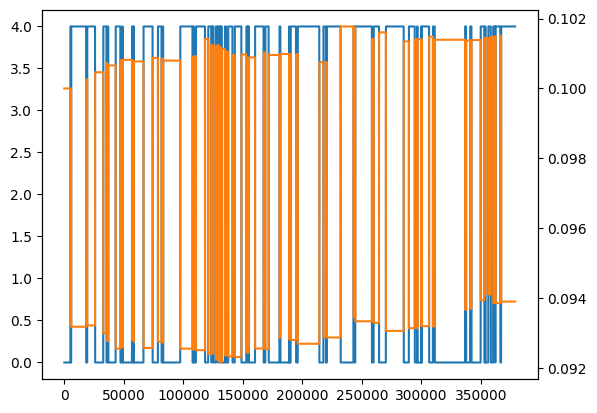

In [31]:
bal.COMP.plot()
bal.BTC.plot(secondary_y=True)

<Axes: >

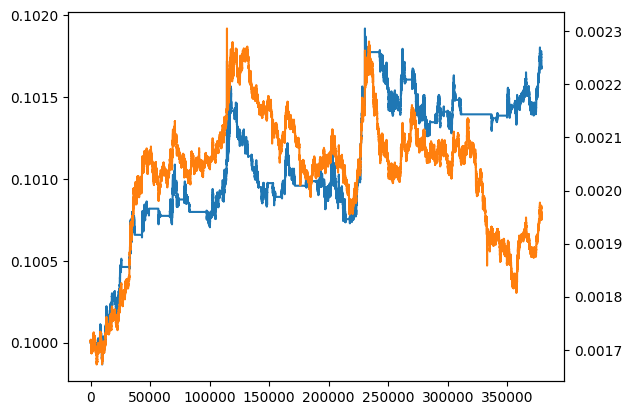

In [32]:
bal.combined.plot()
bal.mid.plot(secondary_y=True)